In [21]:
import os 
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import hashlib
from skimage.measure import shannon_entropy


Assigning the folder to Test_Dir 


In [2]:
TEST_DIR = "input_test"

Printing down the list of images in Input_Test Files 


In [3]:
test_images = os.listdir(TEST_DIR)
print("Total Test Images:", len(test_images))

Total Test Images: 1055


The total number images is 1055 

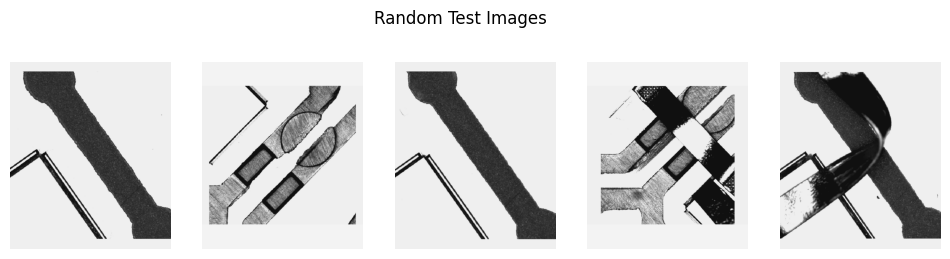

In [4]:
sample_imgs = random.sample(test_images, 5)

plt.figure(figsize=(12, 3))

for i, file in enumerate(sample_imgs):
    img = cv2.imread(os.path.join(TEST_DIR, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Random Test Images")
plt.show()

conforming that there is no broken images \


In [6]:


heights, widths = [], []

for file in test_images:
    img = cv2.imread(os.path.join(TEST_DIR, file))
    h, w, _ = img.shape
    heights.append(h)
    widths.append(w)

heights = np.array(heights)
widths = np.array(widths)

print("Height -> Min:", heights.min(), "Max:", heights.max(), "Mean:", int(heights.mean()))
print("Width  -> Min:", widths.min(),  "Max:", widths.max(),  "Mean:", int(widths.mean()))


Height -> Min: 630 Max: 1470 Mean: 737
Width  -> Min: 540 Max: 1260 Mean: 631


checking the height and width of the image 


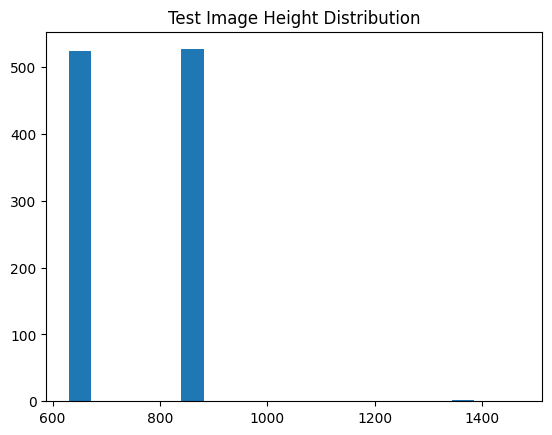

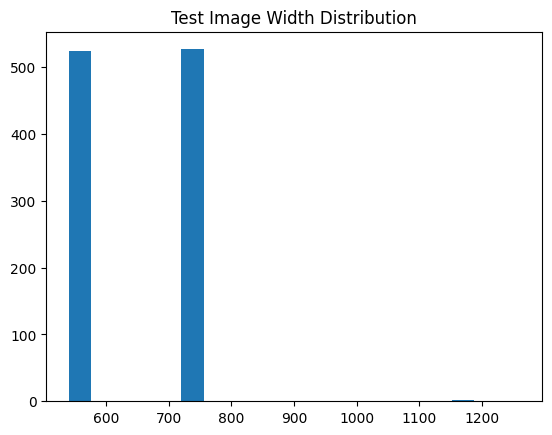

In [7]:
plt.figure()
plt.hist(heights, bins=20)
plt.title("Test Image Height Distribution")
plt.show()

plt.figure()
plt.hist(widths, bins=20)
plt.title("Test Image Width Distribution")
plt.show()


Brightness & Exposure Analysis (Drift Risk Indicator)


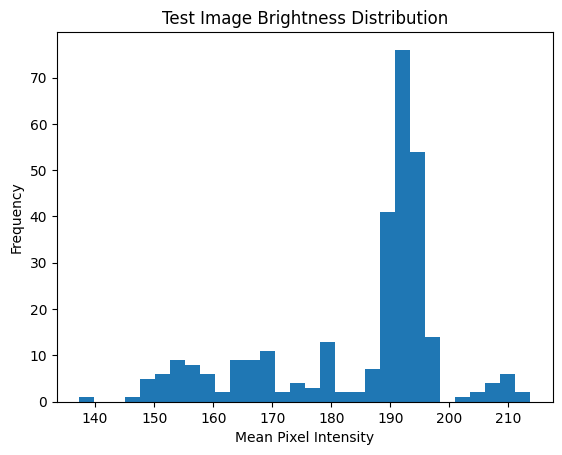

Brightness Range: 137.34896531452088 to 213.70789186507938


In [8]:
gray_means = []

for file in random.sample(test_images, 300):
    img = cv2.imread(os.path.join(TEST_DIR, file), 0)
    gray_means.append(img.mean())

plt.figure()
plt.hist(gray_means, bins=30)
plt.title("Test Image Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

print("Brightness Range:", min(gray_means), "to", max(gray_means))


Color Channel Distribution (Lighting Stability)


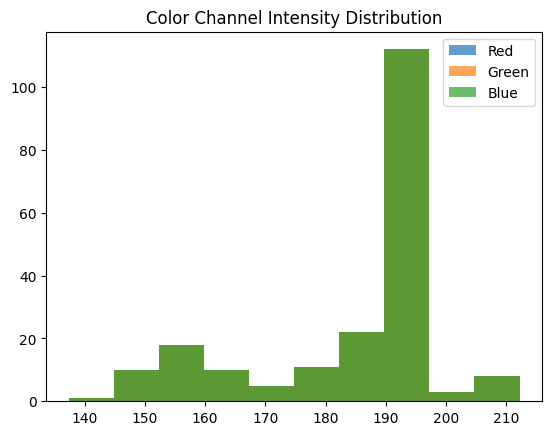

In [9]:
r_vals, g_vals, b_vals = [], [], []

for file in random.sample(test_images, 200):
    img = cv2.imread(os.path.join(TEST_DIR, file))
    b, g, r = cv2.split(img)
    r_vals.append(r.mean())
    g_vals.append(g.mean())
    b_vals.append(b.mean())

plt.figure()
plt.hist(r_vals, alpha=0.7, label="Red")
plt.hist(g_vals, alpha=0.7, label="Green")
plt.hist(b_vals, alpha=0.7, label="Blue")
plt.legend()
plt.title("Color Channel Intensity Distribution")
plt.show()


In [12]:

zero_byte = []
corrupted = []
hashes = {}
duplicates = []

for f in os.listdir(TEST_DIR):
    path = os.path.join(TEST_DIR, f)

    # Zero-byte check
    if os.path.getsize(path) == 0:
        zero_byte.append(f)
        continue

    # Corruption check
    img = cv2.imread(path)
    if img is None:
        corrupted.append(f)
        continue

    # Duplicate check via hash
    with open(path, "rb") as file:
        file_hash = hashlib.md5(file.read()).hexdigest()
        if file_hash in hashes:
            duplicates.append((f, hashes[file_hash]))
        hashes[file_hash] = f

print("Zero-byte files:", zero_byte)
print("Corrupted files:", corrupted)
print("Duplicate pairs:", duplicates[:10])

Zero-byte files: []
Corrupted files: []
Duplicate pairs: []


checking the corruption and its zero


FREQUENCY-DOMAIN TEXTURE ANALYSIS (FFT)

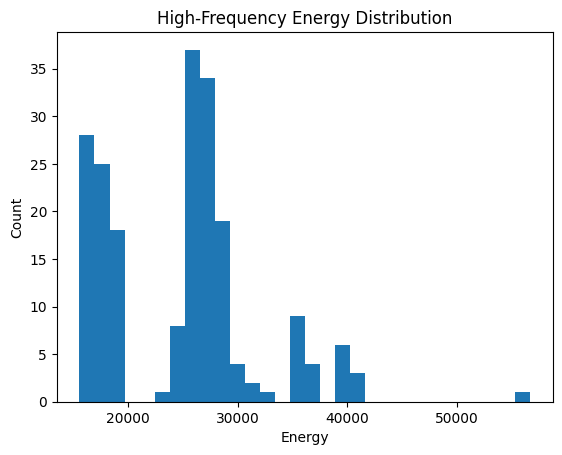

In [13]:

freq_energies = []

for f in os.listdir(TEST_DIR)[:200]:  # sample
    img = cv2.imread(os.path.join(TEST_DIR, f), 0)
    fft = np.fft.fftshift(np.fft.fft2(img))
    magnitude = np.abs(fft)
    
    # High-frequency energy
    hfe = np.mean(magnitude[img.shape[0]//4 : -img.shape[0]//4,
                           img.shape[1]//4 : -img.shape[1]//4])
    freq_energies.append(hfe)

plt.hist(freq_energies, bins=30)
plt.title("High-Frequency Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Count")
plt.show()

EDGE & STRUCTURAL SHARPNESS (SOBEL + CANNY)

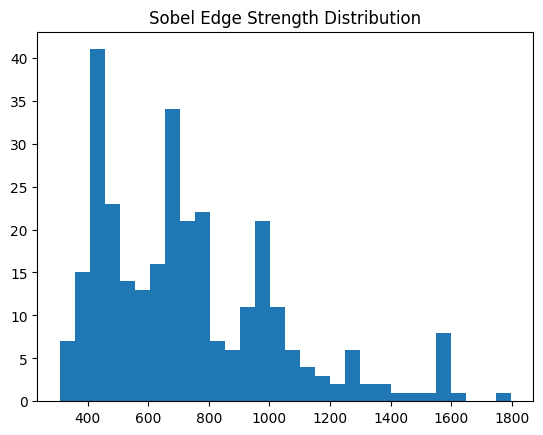

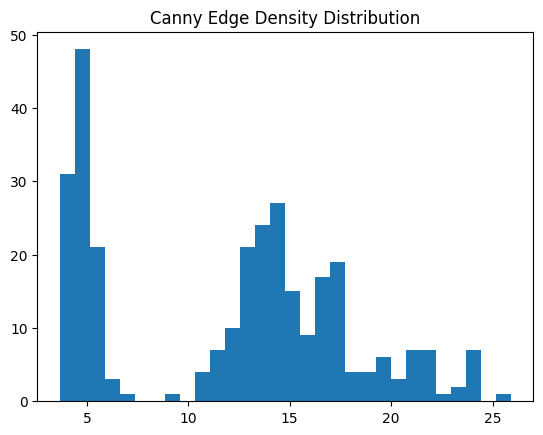

In [14]:
sobel_strength = []
canny_edges = []

for f in os.listdir(TEST_DIR)[:300]:
    img = cv2.imread(os.path.join(TEST_DIR, f), 0)

    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=3)
    sobel_strength.append(sobel.var())

    edges = cv2.Canny(img, 100, 200)
    canny_edges.append(edges.mean())

plt.hist(sobel_strength, bins=30)
plt.title("Sobel Edge Strength Distribution")
plt.show()

plt.hist(canny_edges, bins=30)
plt.title("Canny Edge Density Distribution")
plt.show()


roi centering analysis

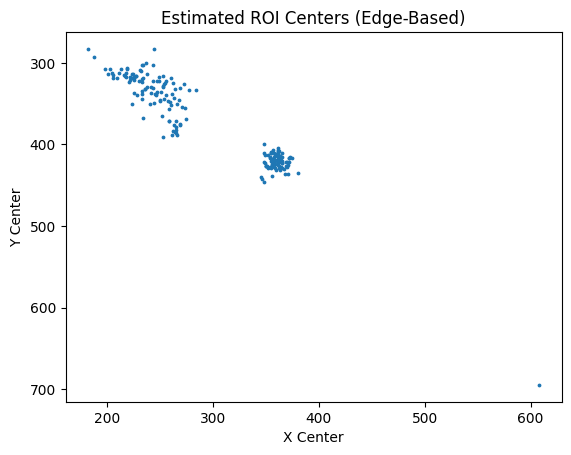

In [15]:
centers_x = []
centers_y = []

for f in os.listdir(TEST_DIR)[:200]:
    img = cv2.imread(os.path.join(TEST_DIR, f), 0)
    edges = cv2.Canny(img, 50, 150)
    ys, xs = np.where(edges > 0)
    centers_x.append(np.mean(xs))
    centers_y.append(np.mean(ys))

plt.scatter(centers_x, centers_y, s=3)
plt.gca().invert_yaxis()
plt.title("Estimated ROI Centers (Edge-Based)")
plt.xlabel("X Center")
plt.ylabel("Y Center")
plt.show()

COMPRESSION ARTIFACT ANALYSIS

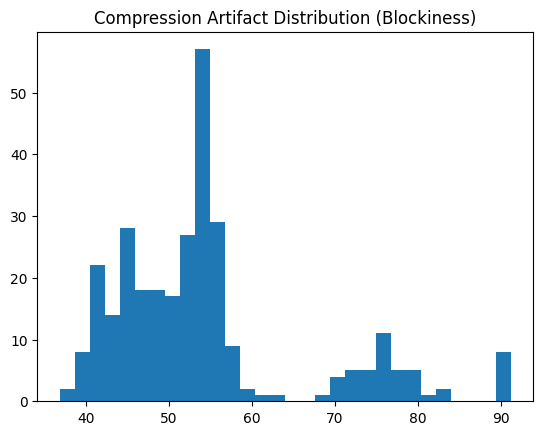

In [16]:
def blockiness(img):
    h, w = img.shape
    diff_h = np.abs(img[:,1:] - img[:,:-1]).sum()
    diff_v = np.abs(img[1:,:] - img[:-1,:]).sum()
    return (diff_h + diff_v) / (h * w)

block_scores = []

for f in os.listdir(TEST_DIR)[:300]:
    img = cv2.imread(os.path.join(TEST_DIR, f), 0)
    block_scores.append(blockiness(img))

plt.hist(block_scores, bins=30)
plt.title("Compression Artifact Distribution (Blockiness)")
plt.show()


ENTROPY ANALYSIS (Information Density)

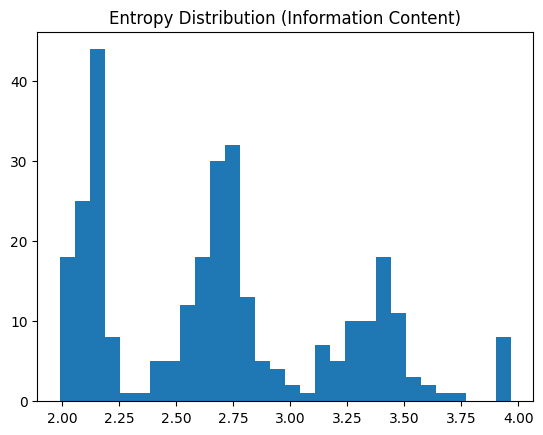

In [22]:


entropies = []

for f in os.listdir(TEST_DIR)[:300]:
    img = cv2.imread(os.path.join(TEST_DIR, f), 0)
    entropies.append(shannon_entropy(img))

plt.hist(entropies, bins=30)
plt.title("Entropy Distribution (Information Content)")
plt.show()


. SCORING-RISK EDA (Strategic EDA for Competition)

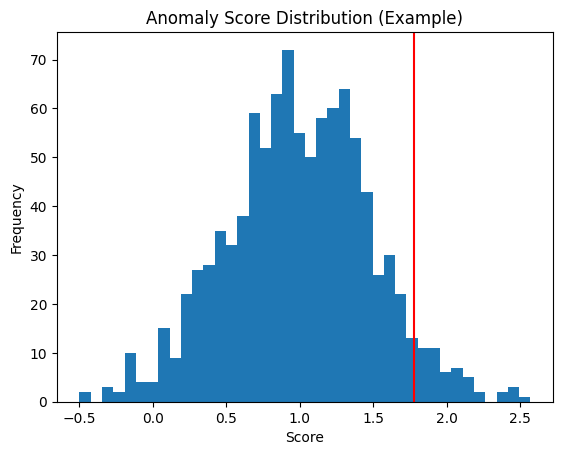

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Example: dummy PADIM score simulation for analysis structure
scores = np.random.randn(1000)*0.5 + 1.0

plt.hist(scores, bins=40)
plt.title("Anomaly Score Distribution (Example)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.axvline(np.percentile(scores, 95), color='red')
plt.show()
